In [15]:
# Download the libraries 
from datetime import datetime
import yfinance as yf
import pandas as pd 
import numpy as np 

from pypfopt.efficient_frontier import EfficientFrontier 
from pypfopt import risk_models
from pypfopt import expected_returns
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices

import numpy as np
import pandas as pd
import plotly.express as ply
import matplotlib.pyplot as plt 
import seaborn as sb
from datetime import date

import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_data(startdate, enddate, stocklist): 
    """
    * This function retrieves the Adjusted close price from the historical data 
      for each stock in the list, for the given date range.
    * Enter dates as "yyyymmdd" 
    """
    start_date=datetime.strptime(startdate, '%Y%m%d').date()
    end_date=datetime.strptime(enddate, '%Y%m%d').date()
    data = yf.download(stocklist, start=start_date, end=end_date, progress=False)
    return data['Adj Close'].copy()


In [3]:
def optimize_portfolio(dataframe, method='sharpe'): 
    """
    The function takes a datafame containing historical stock prices and an optional string argument 'method'
    representing the optimization method. You can choose from two options: 
        * 'sharpe':  (default) Optimize the portfolio for the the highest Sharpe ratio; 
        * 'risk': Optimize the portfolio for the the highest return for a given target risk;
    The function returns the expected annualized return, the annualized volatility, the Sharpe ratio of the portfolio and a dictionary containing the optimized portfolio weights. 
    """
    # Calculate expected returns and sample covariance
    mu = expected_returns.mean_historical_return(dataframe)
    S = risk_models.sample_cov(dataframe)

    # Obtain the efficient frontier
    ef = EfficientFrontier(mu, S)

    # Select a chosen optimal portfolio
    if method == 'sharpe':
        raw_weights = ef.max_sharpe()
    elif method == 'risk':
        user_input = float(input("Enter desired volatility (must be above 0.2): "))
        if user_input <= 0.2:
            raise ValueError("Please enter a volatility above 0.2)")
        raw_weights = ef.efficient_risk(user_input)
    else:
        raise ValueError("Please enter a valid input for method (sharpe, risk)")

    cleaned_weights = ef.clean_weights()

    # Store the portolio performance numbers in variables
    ear, av, sr = ef.portfolio_performance()

    return cleaned_weights, ear, av, sr

In [4]:
def info(df, method='sharpe'):
    """
    This function shows the following portfolio numbers: 
    * return
    * volatility
    * Sharpe ratio
    """
    # Optimize the portfolio 
    weights,ear,av,sr=optimize_portfolio(df,method)
    # Print performance numbers
    print(f'Expected annual return: {ear.round(2)*100}%')
    print(f'Annual volatility: {av.round(2)*100}%')
    print(f'Sharpe ratio: {sr.round(2)*100}%')

In [5]:
def number_of_stocks_to_buy(df, method='sharpe'):
    investment = float(input("Enter the investment amount ($): "))
    if investment != '' :
        # Optimize the portfolio 
        weights, ear, av, sr = optimize_portfolio(df,method)
        # Get latest stock prices (last row) 
        latest_prices = get_latest_prices(df)
        discrete_allocation = DiscreteAllocation(weights, latest_prices , total_portfolio_value = float(investment))
        allocation , leftover = discrete_allocation.lp_portfolio()

        allocation_list = []

        for symbol in allocation:
            allocation_list.append(allocation.get(symbol))

        portfolio_df = pd.DataFrame(list(allocation.items()), columns=['Stock', '# stocks to buy'])
        portfolio_df['Price per stock'] = np.round(latest_prices.loc[portfolio_df['Stock']].values,2)
        portfolio_df['Total'] = portfolio_df['# stocks to buy'] * portfolio_df['Price per stock']
        total=round(portfolio_df.Total.sum(),2)
        left=round(investment-total,2)
        print('Number of stocks to buy with the amount of $ ' + str(investment))
        print(portfolio_df)
        print(f"Total paid for this portfolio: ${total}. Remaining funds : $ {left}")

In [6]:
def pie_plot(df, method='sharpe'): 

    weights,ear,av,sr=optimize_portfolio(df,method)

    # Filter out the zero values from the dictionary
    nonzero_weights = {k: v for k, v in weights.items() if v != 0}

    # Convert the weights to percentages
    total_weight = sum(nonzero_weights.values())
    percentages = [100 * v / total_weight for v in nonzero_weights.values()]

    # Create a list of labels for the pie chart
    labels = list(nonzero_weights.keys())

    # Plot the pie chart
    fig, ax = plt.subplots()
    ax.pie(percentages, labels=labels, autopct='%1.1f%%')
    ax.set_title('Cleaned Weights')

    return plt.show()

In [7]:
def optimal_df(df, method='sharpe'): 
    """
    This function returns the stock prices of the selected stocks by 
    the chosen optimalization method. It will also add a column with the 
    stock prices depending on the (optimal) weights. 
    """
    # df=df.copy()
    weights,ear,av,sr=optimize_portfolio(df,method)
    selected_stocks = [k for k, v in weights.items() if v != 0]
    df_selected=df[selected_stocks]
    df_selected['Best portfolio'] = 0

    for symbol, weight in weights.items():
        if weight !=0:
            df_selected['Best portfolio'] += df_selected[symbol]*weight
    
    return df_selected



In [9]:
def plot_returns(df):  
    """
     function takes a dataframe, calculates its daily and cumulative returns,
     and returns a line plot of the cumulative returns over time. You can 
     see how the investment of 100 $ will evolve over time. 
    """
    #Calculate dailty return
    d_returns = df.pct_change().dropna() 
    #Daily cumulative returns 
    d_cum_returns = (1 + d_returns).cumprod()*100
    fig = ply.line(d_cum_returns, title="Cumulative returns of stocks with initial investment of $100")
    return fig



In [21]:
def ef_plo(df):
        # Calculate expected returns and sample covariance
    mu = expected_returns.mean_historical_return(df)
    S = risk_models.sample_cov(df)

    # Obtain the efficient frontier
    ef = EfficientFrontier(mu, S)
    plotting.plot_efficient_frontier(ef ,points=100 , show_assets = True)

Expected annual return: 21.0%
Annual volatility: 24.0%
Sharpe ratio: 79.0%

Number of stocks to buy with the amount of $ 10000.0
  Stock  # stocks to buy  Price per stock    Total
0   MMC               22           164.92  3628.24
1  MSFT               19           239.22  4545.18
2   TGT               12           148.11  1777.32
Total paid for this portfolio: $9950.74. Remaining funds : $ 49.26
Let's see how your basket looks like: 


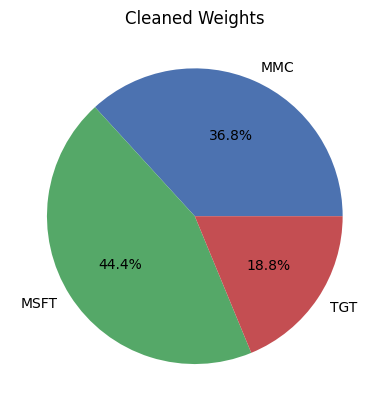

Here are the most recent stock prices of your stocks and (optimal) portfolio:

                   MMC        MSFT         TGT  Best portfolio
Date                                                          
2022-12-23  165.026871  238.133545  142.257996      193.246732
2022-12-27  165.873978  236.367981  144.643051      193.221198
2022-12-28  164.040237  233.944031  144.891479      191.515781
2022-12-29  166.212830  240.407837  147.445465      195.667113
2022-12-30  164.917236  239.220825  148.111282      194.787758

The following graph shows how your investment of 100 dollars would evolve over time


In [23]:
#Example
stock_list = ['MSFT', 'MMC', 'NI', 'BAX', 'CNP', 'TGT', 'JPM', 'BA']

# Read in price data example between 01 jan 2018 and 01 jan 2023
df = get_data("20180101","20230101",stock_list)

# mu = expected_returns.mean_historical_return(df)
# S = risk_models.sample_cov(df)

# # Obtain the efficient frontier
# ef = EfficientFrontier(mu, S)
# ef.max_sharpe()


info(df)
print("")
number_of_stocks_to_buy(df)
print("Let's see how your basket looks like: ")
pie_plot(df)
print("Here are the most recent stock prices of your stocks and (optimal) portfolio:")
print("")
df_opt=optimal_df(df)
print(df_opt.tail())
print("")
print("The following graph shows how your investment of 100 dollars would evolve over time")
plot_returns(df_opt)



Predicting future prices!